In [1]:
# Imports
from datetime import datetime
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras

In [2]:
# Functions
def plot_train_result(data, metric, ax=None):
    """Helper to plot training result curves."""
    if not ax:
        ax = plt.gca()
    ax.plot(data[metric], label='Train')
    ax.plot(data[f"val_{metric}"], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(f"Training process: {metric}")
    ax.legend()
    ax.grid()
    return ax

In [3]:
# Function to load images to test with
input_size = (299, 299)
classes = sorted(os.listdir('../data/processed/train'))

def load_image(path):
    img = Image.open(path)
    rv = img.resize(input_size, Image.BILINEAR)
    rv = np.asarray(rv) / 255.
    return rv.reshape(1, *input_size, 3)

In [4]:
# Build the model
# - Construct the base model
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet', include_top=False
)

base_model.trainable = True
for layer in base_model.layers[:-(19+62)]:
    layer.trainable = False

# - Construct the full model
model = keras.Sequential([
    # - InceptionV3 base
    base_model,
    # - A pooling layer
    keras.layers.GlobalAveragePooling2D(),
    # - First dense layer
    keras.layers.Dense(1024, activation='relu'),
    # - Dropout layer
    keras.layers.Dropout(0.5),
    # - Second dense layer
    keras.layers.Dense(512, activation='relu'),
    # - Second dropout layer
    keras.layers.Dropout(0.3),
    # - Output layer
    keras.layers.Dense(120, activation='softmax')
])

W0805 01:29:45.301668 140273644978304 deprecation.py:506] From /home/doug/.local/share/virtualenvs/dog-breed-model.git-mvQFKgnj/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# Load weights from disk
with open('../models/final/history.pkl', 'rb') as fin:
    history = pickle.load(fin)
with open('../models/final/history_fine.pkl', 'rb') as fin:
    history_fine = pickle.load(fin)
model.load_weights('../models/final/fine_model.hdf5')
model.trainable = False

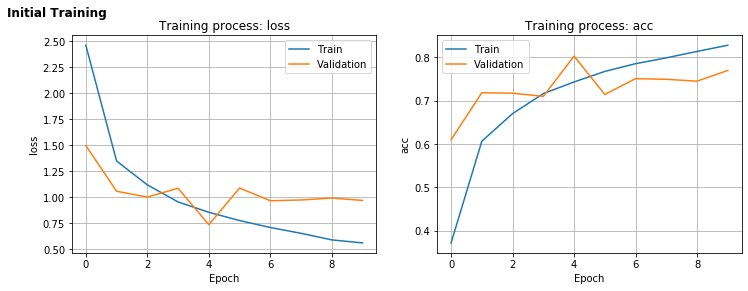

In [6]:
# Plot phase 1 training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_train_result(history, 'loss', ax=axs[0])
plot_train_result(history, 'acc', ax=axs[1])
fig.suptitle('Initial Training', x=0.05, ha='left', fontweight='bold')
fig.savefig('../media/init_train_graph.png')

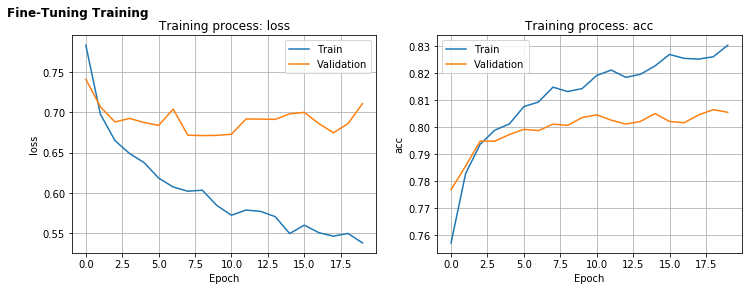

In [7]:
# Plot phase 2 training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_train_result(history_fine, 'loss', ax=axs[0])
plot_train_result(history_fine, 'acc', ax=axs[1])
fig.suptitle('Fine-Tuning Training', x=0.05, ha='left', fontweight='bold')
fig.savefig('../media/fine_train_graph.png')

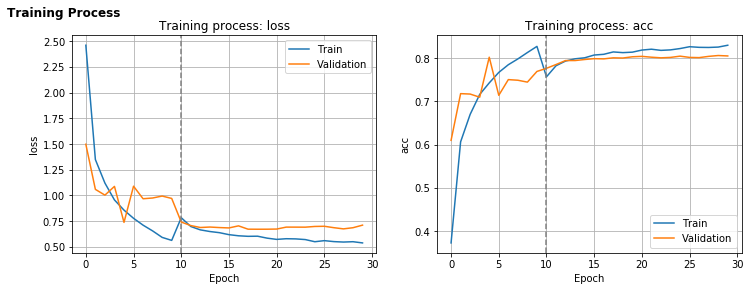

In [8]:
# Combine and plot histories
hist_comb = history.copy()
for k in hist_comb:
    hist_comb[k].extend(history_fine[k])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = plot_train_result(hist_comb, 'loss', ax=axs[0])
ax.axvline(10, linestyle='--', color='gray')

ax = plot_train_result(hist_comb, 'acc', ax=axs[1])
ax.axvline(10, linestyle='--', color='gray')

fig.suptitle('Training Process', x=0.05, ha='left', fontweight='bold')

fig.savefig('../media/train_process.png');

In [9]:
# Function to test the model
def show_image(path):
    """Show the image."""
    img_path = os.path.join('../media', path)
    raw_img = Image.open(img_path)
    ax = plt.imshow(raw_img).axes
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
    
def get_breed(path, top=1):
    """Get the predicted breed from the given image."""    
    img_data = load_image(os.path.join('../media', path))
    y_probs = model.predict_proba(img_data).flatten()
    rv = []
    for i in range(top):
        t_idx = y_probs.argmax()
        rv.append((classes[t_idx], y_probs[t_idx]))
        y_probs[t_idx] = 0.
    return rv

def test_model(path):
    """Show the image and print the predictions."""
    preds = get_breed(path, top=5)
    cm_prob = 0.
    best_guess = None
    for i, (breed, prob) in enumerate(preds):
        cm_prob += prob
        if i == 0:
            best_guess = breed
        if i > 0 and cm_prob > 0.90:
            break
        print(f"#{i+1}: {breed.replace('_', ' ')} ({round(100*prob, 1)}%))")
    ax = show_image(path)
    ax.set_title(best_guess)
    return

#1: German Shepherd (99.8%))


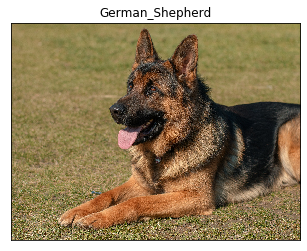

In [10]:
# Test: German Shepherd
test_model('german-shepherd.jpg')

#1: American Staffordshire Terrier (84.4%))


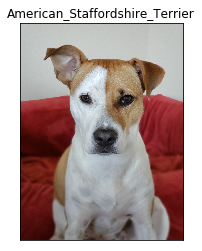

In [11]:
# Test: American Staffordshire Terrier
test_model('staffie.jpg')

#1: Pembroke (88.5%))


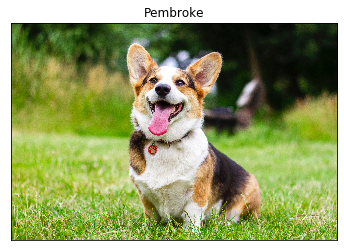

In [12]:
# Test: Corgi
test_model('corgi.jpg')

#1: Pembroke (84.2%))
#2: Cardigan (5.0%))


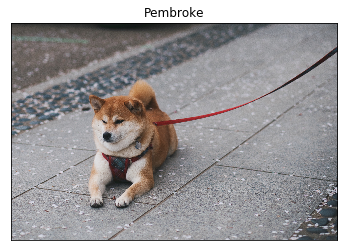

In [13]:
# Test: Shiba Inu
test_model('shiba-inu.jpg')

#1: Rottweiler (96.6%))


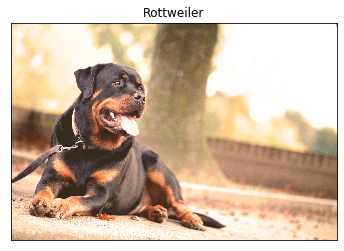

In [14]:
# Test: Rottweiler
test_model('rottie.jpg')

#1: Maltese Dog (31.7%))
#2: Toy Poodle (20.0%))
#3: Lhasa (17.0%))
#4: Dandie Dinmont (8.7%))
#5: Miniature Poodle (7.0%))


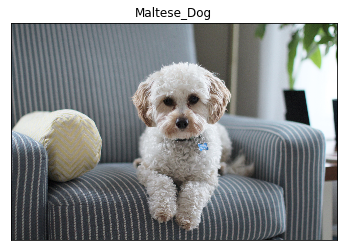

In [15]:
# Test: Havanese? Poodle?
test_model('maybe-havanese.jpg')